## Извлечение отношений
Подготовим данные.

In [1]:
import json
import os
from collections import Counter
from itertools import combinations
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from scipy.sparse import hstack
from collections import defaultdict
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import gensim
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

In [2]:
data = json.load(open('train.json'))
c = Counter([len(data[k]) for k in data])

In [3]:
# сущности
ent1 = []
ent2 = []

# контексты и целые предложения
left = []
right = []
middle = []
sents = []

# целевая переменная
target = []

for key in data:
    for instance in data[key]:
        tokens = instance['tokens']
        sents.append(tokens)
        
        ent1.append(' '.join([tokens[i] for i in instance['h'][2][0]]))
        ent2.append(' '.join([tokens[i] for i in instance['t'][2][0]]))

        if instance['h'][2][0][0] < instance['t'][2][0][0]:
            first, second = 'h', 't'
        else:
            second, first = 'h', 't'

        # индексы сущностей
        first_start = instance[first][2][0][0]
        first_end = instance[first][2][0][-1]
        second_start = instance[second][2][0][0]
        second_end = instance[second][2][0][-1]

        # левый контекст - это три слова слева от начала первой сущности
        # если слева меньше 3 слов, то добавим тэгов <START>
        left_context = tokens[max(0, first_start-3):first_start]
        left.append((['<START>']*(3-len(left_context))) + left_context)
        
        # правый контекст - это 3 слова после последнего слова второй сущности
        # если справа меньше 3 слов, то добавим тэгов <END>
        right_context = tokens[second_end+1:second_end+4]
        right.append(right_context + (['<END>']*(3-len(right_context))))

        # средний контекст - это слова между последний словом первой сущности 
        # и первым словом второй сущности
        middle_context = tokens[first_end+1:second_start]
        middle.append(middle_context)

        target.append(key)

Склеим токены для обучения.

In [4]:
lefts_s = [' '.join(l) for l in left]
rights_s = [' '.join(l) for l in right]
middles_s = [' '.join(l) for l in middle]
sents_s = [' '.join(l) for l in sents]

### Обучение по word2vec
Использованы данные из nltk.corpus.reuters и новостного корпуса с семинара.
Соберём данные из обеих частей и сконкатенируем в один корпус.

In [5]:
from nltk.corpus import reuters

reuters_docs=[]
for category in reuters.categories():
    for fileid in reuters.fileids(category):
        reuters_docs.append([x for x in reuters.raw(fileid).split()])

In [6]:
news_docs=[]
for ddd in os.listdir('news'):
    with open(os.path.join(os.path.join(os.getcwd(), 'news'), ddd), 'r', encoding='utf-8') as f:
        d = json.load(f)
        if 'text' in d.keys():
            news_docs.append([x for x in d['text'].split()])

In [7]:
reuters_docs.extend(news_docs)

Обучим модель на сконкатенированном корпусе.

In [8]:
model = gensim.models.Word2Vec(reuters_docs)

Теперь займёмся эмбеддингами. Размерность задал 100, потому что старому ноуту тяжело. :(

In [18]:
def get_embedding(text, model, dim = 100):
    text = text.split()
    words = Counter(text)
    total = len(text)
    vectors = np.zeros((len(words), dim))    
    for i,word in enumerate(words):
        try:
            v = model[word]
            vectors[i] = v*(words[word]/total)
        except (KeyError, ValueError):
            continue   
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((dim))    
    return vector     

Создадим эмбеддинги для каждого окна отдельно, затем сконкатенируем получившиеся матрицы:

In [19]:
X_l = np.zeros((len(lefts_s), 100))
for i, text in enumerate(lefts_s):
    X_l[i] = get_embedding(text, model)
    
X_m = np.zeros((len(middles_s), 100))
for i, text in enumerate(middles_s):
    X_m[i] = get_embedding(text, model)
    
X_r = np.zeros((len(rights_s), 100))
for i, text in enumerate(rights_s):
    X_r[i] = get_embedding(text, model)

In [20]:
from scipy.sparse import coo_matrix
X = csr_matrix(hstack([coo_matrix(X_l), coo_matrix(X_m), coo_matrix(X_r)]))

Теперь настал черёд эмбеддингов для целых предложений:

In [22]:
X_s = np.zeros((len(sents_s), 100))

for i, text in enumerate(sents_s):
    X_s[i] = get_embedding(text, model)

X_ = csr_matrix(X_s)
y = np.array(target)

### Эмбеддинги по окнам (logreg)

In [24]:
N = 4
skf = StratifiedKFold(n_splits=N, shuffle=True)
metrics_macro = np.zeros((3))
metrics_micro = np.zeros((3))
conf = np.zeros((len(set(y)), len(set(y))))

for train_index, test_index in skf.split(X, y):
    clf = LogisticRegression()
    clf.fit(X[train_index], y[train_index])
    preds = clf.predict(X[test_index])
    
    metrics_macro += precision_recall_fscore_support(y[test_index], preds, average='macro')[:3]
    metrics_micro += precision_recall_fscore_support(y[test_index], preds, average='micro')[:3]
    
    conf += confusion_matrix(y[test_index], preds)

In [25]:
print(metrics_micro/N)
print(metrics_macro/N)

[0.2221875 0.2221875 0.2221875]
[0.21624506 0.2221875  0.20438507]


### Эмбеддинги целых предложений (SGD)

In [26]:
from sklearn.linear_model import SGDClassifier

N = 4
skf = StratifiedKFold(n_splits=N, shuffle=True)
metrics_macro = np.zeros((3))
metrics_micro = np.zeros((3))
conf = np.zeros((len(set(y)), len(set(y))))

for train_index, test_index in skf.split(X, y):
    clf = SGDClassifier()
    clf.fit(X_[train_index], y[train_index])
    preds = clf.predict(X_[test_index])
    
    metrics_macro += precision_recall_fscore_support(y[test_index], preds, average='macro')[:3]
    metrics_micro += precision_recall_fscore_support(y[test_index], preds, average='micro')[:3]
    
    conf += confusion_matrix(y[test_index], preds)

In [27]:
print(metrics_micro/N)
print(metrics_macro/N)

[0.13089286 0.13089286 0.13089286]
[0.24525157 0.13089286 0.10506499]


Для первой группы эмбеддингов лучше сработал классификатор на логистической регрессии, для второй -- метод стохастического градиента. При этом результаты всё равно получились весьма скромные, что там, что тут. Думается, причина кроется в датасете и невысокой размерности матриц.

### Матрица ошибок (logreg)

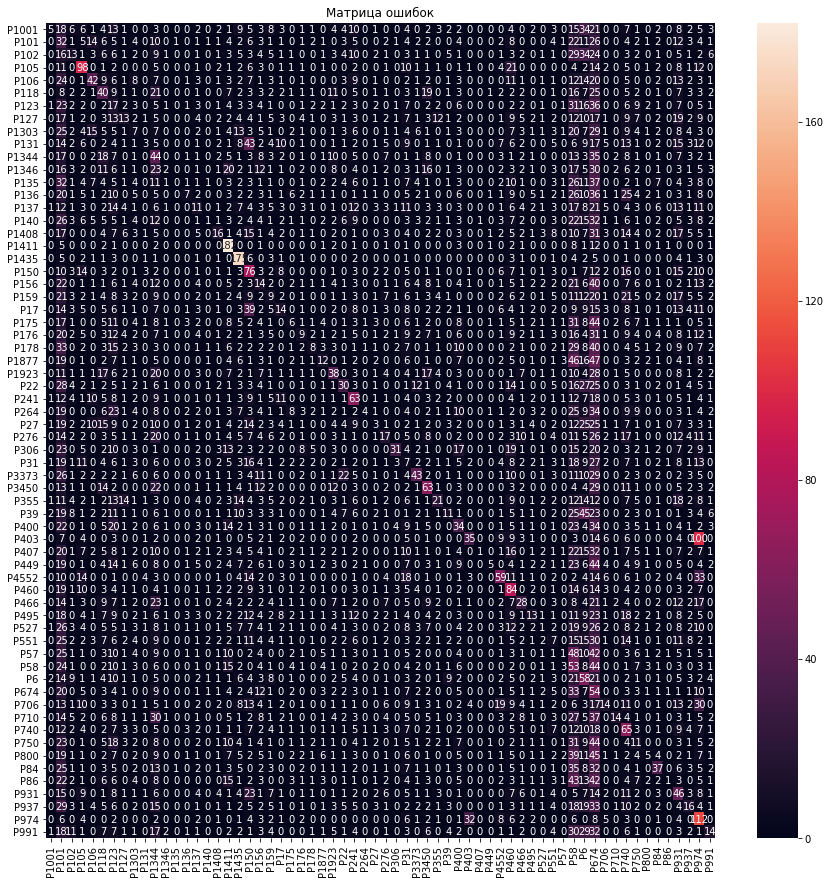

In [29]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data=np.round(conf/3).astype(int), 
            annot=True, 
            fmt="d", xticklabels=clf.classes_, yticklabels=clf.classes_, ax=ax)
plt.title("Матрица ошибок")
plt.show()

Ошибок хватает, особенно не повезло классам P58, P6 и P674 (слишком уж они оказались "размытыми"), с которыми классификатор путал каждый второй класс. Также довольно часто классификатор ошибается при попытке отличить P403 от P974, поскольку и в том, и в другом в предложениях подряд следуют названия водоёмов.

In [34]:
data['P403']

[{'h': ['mackenzie', 'Q3411', [[22]]],
  't': ['beaufort sea', 'Q131274', [[15, 16]]],
  'tokens': ['The',
   'Peel',
   'watershed',
   'drains',
   '14',
   '%',
   'of',
   'the',
   'Yukon',
   'Territory',
   'Canada',
   'and',
   'flows',
   'into',
   'the',
   'Beaufort',
   'Sea',
   'via',
   'the',
   'Peel',
   'and',
   'then',
   'Mackenzie',
   'Rivers',
   '.']},
 {'h': ['coquille river', 'Q2996943', [[1, 2]]],
  't': ['pacific ocean', 'Q98', [[23, 24]]],
  'tokens': ['The',
   'Coquille',
   'River',
   'starts',
   'in',
   'the',
   'Siskiyou',
   'National',
   'Forest',
   'and',
   'flows',
   'hundreds',
   'of',
   'miles',
   'through',
   'the',
   'Coquille',
   'Valley',
   'on',
   'its',
   'way',
   'to',
   'the',
   'Pacific',
   'Ocean',
   '.']},
 {'h': ['rogue river', 'Q1848950', [[1, 2]]],
  't': ['pacific ocean', 'Q98', [[5, 6]]],
  'tokens': ['The',
   'Rogue',
   'River',
   'meets',
   'the',
   'Pacific',
   'Ocean',
   'at',
   'Gold',
   'Be

In [35]:
data['P974']

[{'h': ['hudson river', 'Q3140', [[18, 19]]],
  't': ['schroon river', 'Q7432908', [[14, 15]]],
  'tokens': ['The',
   'east',
   'side',
   'of',
   'Grace',
   'Peak',
   'drains',
   'into',
   'Lindsay',
   'Brook',
   ',',
   'thence',
   'into',
   'the',
   'Schroon',
   'River',
   ',',
   'the',
   'Hudson',
   'River',
   ',',
   'and',
   'into',
   'New',
   'York',
   'Bay',
   '.']},
 {'h': ['kaczawa', 'Q1720921', [[22]]],
  't': ['raging neisse', 'Q1641953', [[11, 12]]],
  'tokens': ['Between',
   'Gniewków',
   'and',
   'Czernica',
   ',',
   'the',
   'Little',
   'Neisse',
   'discharges',
   'into',
   'the',
   'Raging',
   'Neisse',
   ',',
   'the',
   'largest',
   'and',
   'most',
   'important',
   'tributary',
   'of',
   'the',
   'Kaczawa',
   '.']},
 {'h': ['oder', 'Q552', [[12]]],
  't': ['lusatian neisse', 'Q5602', [[7, 8]]],
  'tokens': ['Near',
   'the',
   'village',
   'of',
   'Ratzdorf',
   ',',
   'the',
   'Lusatian',
   'Neisse',
   'discharges